# Train_recognition model

## Imports

In [5]:
import gc
import re
import json
import random
from itertools import chain
from tqdm.auto import tqdm
import difflib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageEnhance
import cv2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset, SequentialSampler, RandomSampler

from torchvision.transforms import v2
import albumentations as A

from torchmetrics.text import CharErrorRate, WordErrorRate
from torchmetrics.functional.text import char_error_rate, word_error_rate
import Levenshtein

from doctr.io import DocumentFile
from doctr.models import ocr_predictor, recognition, detection
from doctr.transforms import Resize
from doctr.datasets import WordGenerator, RecognitionDataset

from doctr.datasets import DetectionDataset
from doctr import transforms as T
from doctr.utils.metrics import LocalizationConfusion
from doctr.models.preprocessor import PreProcessor

from castom_utils import *

In [ ]:
SEED = 42

IS_CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', 
      f'({torch.cuda.get_device_name()})' 
      if torch.cuda.is_available() else '')

In [ ]:
CFG = load_config()

## dataset

In [11]:
class RecognitionDataset(Dataset):
    
    def __init__(self, path, transform=None, transform_alb=None):
        self.path = path

        with open(path.joinpath('labels.json'), 'r', encoding="utf-8") as file:
            labels = json.load(file)
    
        for img_name, label in labels.items():
            if not path.joinpath('images', img_name).exists():
                raise FileNotFoundError(f"unable to locate {Path('dataset/train', img_name)}")

        self.labels = list(labels.items())
        self.transform = transform
        self.transform_alb = transform_alb

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name, target = self.labels[idx]
        img = Image.open(self.path.joinpath('images', img_name)).convert('RGB')

        if self.transform_alb is not None:
            img = np.array(img)
            img = self.transform_alb(image=img)['image']

        if self.transform is not None:
            img = self.transform(img)

        return img, target

In [12]:
# Случайные аугментации
transform_albumentations = A.Compose([
    # Добавление Gaussian шума
    A.GaussNoise(var_limit=(100, 600), p=.4),

    # # Добавление артефактов
    # A.CoarseDropout(
    #     num_holes_range=(3, 7), 
    #     hole_height_range=(5, 9), 
    #     hole_width_range=(5, 9), 
    #     fill_value=(255, 255, 255), 
    #     p=.3
    # ),
        
    # Размытие
    A.GaussianBlur(blur_limit=(1, 3), p=.3),

    # Эффект искажения линий
    A.ElasticTransform(alpha=3, sigma=50, p=.35),
    
    # Искажения геометрии
    A.Perspective(scale=(.002, .004), p=.3),
    
    # Изменение яркости и контраста
    # A.RandomBrightnessContrast(
    #     brightness_limit=(-.1, .1), 
    #     contrast_limit=(-.1, .1), 
    #     p=.6
    # ),
    A.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.2, p=.4),
    
    # Эффект тени
    A.RandomShadow(
        shadow_roi=(0, 0, 1, 1),
        num_shadows_lower=1, 
        num_shadows_upper=4, 
        shadow_intensity_range=(.9, .95), 
        p=.3
    ),
    
    # Эффект засвета
    A.RandomSunFlare(
        flare_roi=(0, 0, 1, 1), 
        angle_range=(.1, 1), 
        src_radius=60, 
        p=.2
    ),
    


    ])

In [13]:
transform = v2.Compose([
    v2.ToImage(),
    
    T.RandomApply(T.RandomShadow(), p=.1),
    v2.RandomPerspective(distortion_scale=.05, p=.3),
    v2.RandomRotation(degrees=1.5, expand=True),
    
    Resize((32, 128), preserve_aspect_ratio=True, symmetric_pad=True),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301))
])

In [14]:
# recognition_dataset = PATH_DATASET.joinpath('recognition')

# train_set_r = RecognitionDataset(recognition_dataset.joinpath('train'), transform=transform, transform_alb=transform_albumentations)
# val_set_r = RecognitionDataset(recognition_dataset.joinpath('val'), transform=transform, transform_alb=transform_albumentations)
# test_set_r = RecognitionDataset(recognition_dataset.joinpath('test'), transform=transform, transform_alb=transform_albumentations)

In [15]:
# recognition_dataset = PATH_DATASET.joinpath('recognition')

In [26]:
from fontTools.ttLib import TTFont

In [27]:
def _is_supported_chars(font_path, unicode_list):
    """
    Проверяет, поддерживает ли шрифт все нужные символы
    """
    try:
        font = TTFont(font_path)
        cmap = font['cmap'].getBestCmap()
        for code in unicode_list:
            if code not in cmap:
                return False
        return True
    except:
        return False

def valid_fonts(fonts_list: list, unicode_list: list):
    """
    Отбирает из списка шрифты, поддеривающие все необходимые символы
    """
    return [font for font in fonts_list if _is_supported_chars(font, unicode_list)]

def get_fonts_from_folder(path: str):
    """
    Возвращает список шрифтов из папки
    """
    path = Path(path)
    fonts = path.rglob('*.ttf')
    return [str(font) for font in fonts]

# Получим список кодов unicode для всех заранее определенных символов, 
unicode_character = list(map(ord, CHARACTER))


total_fonts = get_fonts_from_folder('fonts') # + get_system_fonts()

good_fonts = valid_fonts(total_fonts, unicode_character)
print(f"Найдено подходящих шрифтов: {Ansi.bold}{len(good_fonts)}{Ansi.end}")

Найдено подходящих шрифтов: 279


In [71]:
train_set_r = WordGenerator(
    vocab=CHARACTER,
    min_chars=1,
    max_chars=15,
    num_samples=500 * len(CHARACTER),
    font_family=good_fonts,
    img_transforms=v2.Compose([
        T.Resize((32, 128), preserve_aspect_ratio=True),
        # Ensure we have a 90% split of white-background images
        T.RandomApply(T.ColorInversion(), 0.9),
        v2.RandomGrayscale(p=0.1),
        v2.RandomPhotometricDistort(p=0.1),
        T.RandomApply(T.RandomShadow(), p=0.4),
        T.RandomApply(T.GaussianNoise(mean=0, std=0.1), 0.1),
        T.RandomApply(v2.GaussianBlur(3), 0.3),
        v2.RandomPerspective(distortion_scale=0.2, p=0.3),
        v2.Normalize(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301)),
    ]),
)


val_set_r = WordGenerator(
    vocab=CHARACTER,
    min_chars=1,
    max_chars=15,
    num_samples=100 * len(CHARACTER),
    font_family=good_fonts,
    img_transforms=v2.Compose([
        T.Resize((32, 128), preserve_aspect_ratio=True),
        # Ensure we have a 90% split of white-background images
        T.RandomApply(T.ColorInversion(), 0.9),
        v2.Normalize(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301)),
    ]),
)

In [90]:
recognition_dataset = PATH_DATASET.joinpath('recognition')

train_set_r = RecognitionDataset(
    recognition_dataset.joinpath('train', 'images'),
    recognition_dataset.joinpath('train', 'labels.json'),
    img_transforms=v2.Compose([
        T.Resize((32, 128), preserve_aspect_ratio=True),
        # Augmentations
        T.RandomApply(T.ColorInversion(), 0.1),
        v2.RandomGrayscale(p=0.1),
        v2.RandomPhotometricDistort(p=0.1),
        T.RandomApply(T.RandomShadow(), p=0.4),
        T.RandomApply(T.GaussianNoise(mean=0, std=0.1), 0.1),
        T.RandomApply(v2.GaussianBlur(3), 0.3),
        v2.RandomPerspective(distortion_scale=0.2, p=0.3),
        v2.Normalize(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301)),
    ]),
)

val_set_r = RecognitionDataset(
    recognition_dataset.joinpath('val', 'images'),
    recognition_dataset.joinpath('val', 'labels.json'),
    img_transforms=v2.Compose([
        T.Resize((32, 128), preserve_aspect_ratio=True),
        v2.Normalize(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301)),
    ]),
)

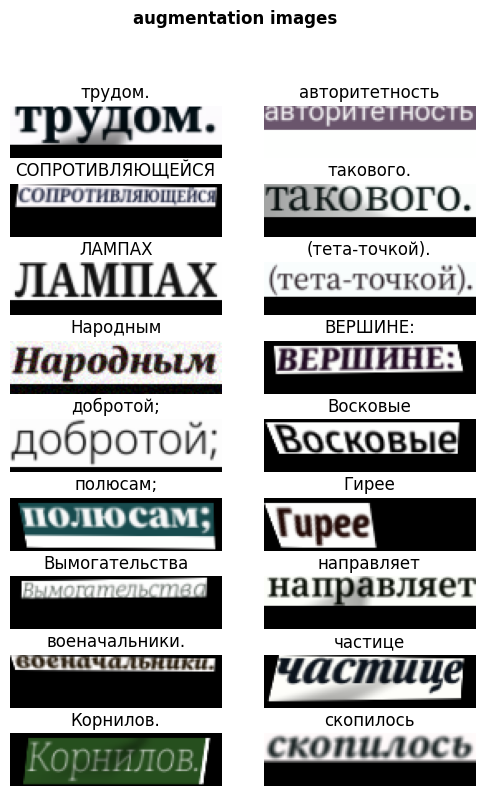

In [93]:
denorm = DeNormalize(mean=(0.694, 0.695, 0.693), std=(0.299, 0.296, 0.301))

def show_images_recognition_dataset(dataset, num=18):
    length = len(dataset)
    indices = np.random.choice(length, min(num, length))

    fig, axes = plt.subplots(num // 2, 2, figsize=(6, num / 2))
    fig.suptitle('augmentation images', fontweight='bold')
    for ax, idx in zip(axes.flat, indices):
        img, target = dataset[idx]
        img = (denorm(img) * 255).to(torch.uint8)
        img = img.numpy().transpose(1, 2, 0)
        ax.set_title(target)
        ax.imshow(img)
        ax.axis('off')
    plt.show()


show_images_recognition_dataset(train_set_r)

In [41]:
BATCH_SIZE = 256

# train_loader_r = DataLoader(train_set_r, batch_size=BATCH_SIZE, shuffle=True)
# val_loader_r = DataLoader(val_set_r, batch_size=BATCH_SIZE, shuffle=False)
# test_loader_r = DataLoader(test_set_r, batch_size=BATCH_SIZE, shuffle=False)

In [95]:
BATCH_SIZE = 256

train_loader_r = DataLoader(
    train_set_r,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
    pin_memory=torch.cuda.is_available(),
    collate_fn=train_set_r.collate_fn,
)

val_loader_r = DataLoader(
    val_set_r,
    batch_size=BATCH_SIZE,
    drop_last=False,
    shuffle=False,
    pin_memory=torch.cuda.is_available(),
    collate_fn=val_set_r.collate_fn,
)

### train

In [58]:
model_recognition = recognition.vitstr_small(pretrained=True, vocab=CHARACTER).to(DEVICE)

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/doctr/models/utils/pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(archive_p

In [59]:
load_state = torch.load('models_doctr/best_recognition_vitstr_small.pth', map_location=DEVICE, weights_only=True)

In [60]:
model_recognition.load_state_dict(load_state['model'])
# optimizer.load_state_dict(load_state['optimizer'])
# scheduler.load_state_dict(load_state['scheduler'])

<All keys matched successfully>

In [96]:
parameters = [p for p in model_recognition.parameters() if p.requires_grad]
optimizer = optim.Adam(parameters, lr=8e-5, betas=(0.95, 0.99), eps=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.6)
best_cer = .05

In [97]:
metric_cer = CharErrorRate()
metric_wer = WordErrorRate()

In [105]:
gc.collect()
torch.cuda.empty_cache()

EPOCHS = 4

for epoch in range(EPOCHS):
    train_loss = []
    last_lr = scheduler.get_last_lr()[0]

    # TRAIN
    model_recognition.train()
    loop = tqdm(train_loader_r, leave=False)
    for images, labels in loop:
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model_recognition(images, labels)
        loss = outputs['loss']
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_recognition.parameters(), 5)
        optimizer.step()

        train_loss.append(loss.detach().item())
        loop_description = f'Epoch [{epoch + 1}/{EPOCHS}], lr: {last_lr:.1e}, loss: {np.mean(train_loss):.4f}'
        loop.set_description(loop_description)

    # VALID
    metric_cer.reset()
    metric_wer.reset()
    model_recognition.eval()
    with torch.no_grad():
        loop = tqdm(val_loader_r, desc='evaluation', leave=False)
        for images, labels in loop:
            images = images.to(DEVICE)
            outputs = model_recognition(images)
            preds = [out[0] for out in outputs['preds']]
    
            metric_cer.update(preds, labels)
            metric_wer.update(preds, labels)

    # Вычисление итоговой метрики
    val_cer = metric_cer.compute().item()
    val_wer = metric_wer.compute().item()

    # Вывод результатов обучения для эпохи
    print(
        loop_description, 
        f"| CER: {Ansi.bold}{val_cer:.4f}{Ansi.end},",
        f"WER: {Ansi.bold}{val_wer:.4f}{Ansi.end}",
        end = ' '
    )

    # Scheduler step
    scheduler.step()
    
    # Save best model
    if best_cer > val_cer:
        best_cer = val_cer
        save_model(model_recognition, optimizer, scheduler, f'best_recognition_epoch_{epoch + 1}')
        print(f'{Ansi.bold}{Ansi.green}save model{Ansi.end}')

    # Save last model
    save_model(model_recognition, optimizer, scheduler, 'last_recognition')

  0%|          | 0/3906 [00:00<?, ?it/s]

evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [1/4], lr: 8.0e-05, loss: 0.0131 | CER: 0.0023, WER: 0.0078 save model


  0%|          | 0/3906 [00:00<?, ?it/s]

evaluation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch [2/4], lr: 4.8e-05, loss: 0.0087 | CER: 0.0015, WER: 0.0053 save model


  0%|          | 0/3906 [00:00<?, ?it/s]

KeyboardInterrupt: 

Epoch [1/6], lr: 1.0e-04, loss: 0.0144 | CER: 0.0036, WER: 0.0198 save model

Epoch [2/6], lr: 6.0e-05, loss: 0.0082 | CER: 0.0028, WER: 0.0162 save model

Epoch [3/6], lr: 3.6e-05, loss: 0.0066 | CER: 0.0020, WER: 0.0125 save model

Epoch [4/6], lr: 2.2e-05, loss: 0.0059 | CER: 0.0021, WER: 0.0128 

Epoch [5/6], lr: 1.3e-05, loss: 0.0053 | CER: 0.0020, WER: 0.0123 save model

Epoch [6/6], lr: 7.8e-06, loss: 0.0052 | CER: 0.0019, WER: 0.0120 save model
